In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [2]:
# load the ratings data
ratings_df = pd.read_csv("ml-latest/ratings.csv").drop("timestamp", axis=1)

In [3]:
# split the data into test and train sets
test_ratings = ratings_df.sample(int(len(ratings_df)*0.2), random_state=0xc00ff3)
sampled_indices = test_ratings.index

test_pairs =  test_ratings[["userId", "movieId"]]
actual_ratings = test_ratings["rating"]

train_ratings = ratings_df.drop(sampled_indices)

del ratings_df

In [4]:
# write tests data to csv
test_ratings.to_csv('test_data/tests.csv', index=False)

In [5]:
# load movie data
movies_df = pd.read_csv("ml-latest/movies.csv").drop("title", axis=1)
movies_df

,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy
...,...,...
86532,288967,Action|Drama
86533,288971,Action|Horror
86534,288975,Documentary
86535,288977,Crime|Thriller


In [6]:
# merge movies with ratings
train_ratings_merged = pd.merge(train_ratings, movies_df, on="movieId")
train_ratings_merged

,userId,movieId,rating,genres
0,1,1,4.0,Adventure|Animation|Children|Comedy|Fantasy
1,2,1,5.0,Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.0,Adventure|Animation|Children|Comedy|Fantasy
3,10,1,3.0,Adventure|Animation|Children|Comedy|Fantasy
4,12,1,5.0,Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...
27065725,330904,228179,4.5,Comedy|Drama
27065726,330904,261553,3.5,Drama
27065727,330904,279870,3.0,Drama|War
27065728,330914,189165,1.0,Children|Comedy|Fantasy


In [7]:
# split genres column into separable rows
train_ratings_merged["genres"] = train_ratings_merged["genres"].str.split("|") 
train_ratings_merged = train_ratings_merged.explode('genres').reset_index(drop=True)
train_ratings_merged

,userId,movieId,rating,genres
0,1,1,4.0,Adventure
1,1,1,4.0,Animation
2,1,1,4.0,Children
3,1,1,4.0,Comedy
4,1,1,4.0,Fantasy
...,...,...,...,...
73692955,330914,189165,1.0,Children
73692956,330914,189165,1.0,Comedy
73692957,330914,189165,1.0,Fantasy
73692958,330922,269782,0.5,Adventure


In [8]:
movies_df.groupby("genres").count()
# we will delete no genres because it is not good for similarity comparison

,movieId
genres,
(no genres listed),7060
Action,783
Action|Adventure,245
Action|Adventure|Animation,43
Action|Adventure|Animation|Children,8
...,...
Thriller|War,16
Thriller|Western,8
War,123


In [9]:
# check average genre score
average_genre_score = train_ratings_merged.drop(["userId", "movieId"], axis=1).groupby("genres").mean()
genre_avg_score_map = average_genre_score['rating'].to_dict()
average_genre_score

,rating
genres,
(no genres listed),3.377577
Action,3.479832
Adventure,3.525999
Animation,3.615493
Children,3.437499
Comedy,3.432230
Crime,3.697110
Documentary,3.693264
Drama,3.685828


In [10]:
# prepare data for training
# create pivot table: rows = userId, columns genres
# into cell feel with mean value of grades from specyfic genre for specyfic user
# drop '(no genres listed)' column
# fill NA with average for given genre
X = train_ratings_merged.pivot_table(index="userId", columns="genres", values="rating", aggfunc="mean").drop("(no genres listed)", axis=1).fillna(genre_avg_score_map)
X


genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,4.142857,4.100000,4.083333,3.937500,3.800000,4.000000,3.693264,4.065217,4.277778,3.915148,3.750000,4.000000,3.833333,3.673741,4.033333,3.625000,4.200000,4.666667,3.595774
2,3.192308,3.470588,4.250000,3.857143,3.600000,3.666667,3.693264,3.676471,3.500000,3.915148,3.500000,4.333333,4.000000,2.500000,3.636364,2.625000,3.454545,4.600000,3.666667
3,4.800000,5.000000,5.000000,5.000000,4.800000,5.000000,3.693264,4.923077,5.000000,3.915148,5.000000,5.000000,3.547354,5.000000,5.000000,4.400000,4.857143,5.000000,5.000000
4,4.250000,4.277778,4.500000,4.285714,4.166667,4.333333,3.693264,4.357143,4.500000,3.915148,3.306805,4.300000,4.500000,3.666667,4.437500,3.900000,4.000000,5.000000,3.595774
5,3.111111,2.500000,3.615493,3.000000,3.181818,3.666667,4.000000,3.714286,2.666667,3.915148,3.000000,3.607470,2.500000,4.250000,3.600000,4.000000,3.416667,3.500000,3.595774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330971,3.843750,4.307692,5.000000,5.000000,3.625000,4.214286,3.693264,4.105263,4.500000,3.915148,4.200000,4.000000,3.547354,3.875000,3.600000,3.687500,3.555556,3.900000,3.666667
330972,2.800000,3.214286,3.625000,3.411765,3.103448,3.375000,3.693264,3.636364,3.444444,3.915148,3.000000,4.000000,3.833333,4.250000,3.375000,3.857143,3.250000,3.600000,3.250000
330973,3.083333,2.750000,3.615493,2.250000,3.071429,3.833333,3.693264,3.583333,2.500000,3.915148,2.500000,4.250000,3.547354,4.000000,4.750000,4.000000,3.333333,3.797732,3.595774


In [11]:
best_k = 14

In [12]:
kmeans = KMeans(n_clusters=best_k, init="k-means++", random_state=0xc00ff3).fit(X)

In [13]:
# assign user to the cluster
user_clusters = pd.DataFrame({"userId": X.index, "cluster": kmeans.labels_}).set_index("userId")
user_clusters

,cluster
userId,
1,2
2,13
3,6
4,2
5,1
...,...
330971,2
330972,13
330973,1


In [14]:
# write to csv
user_clusters.to_csv('model_data/user_cluster.csv') 

<Axes: xlabel='cluster', ylabel='count'>

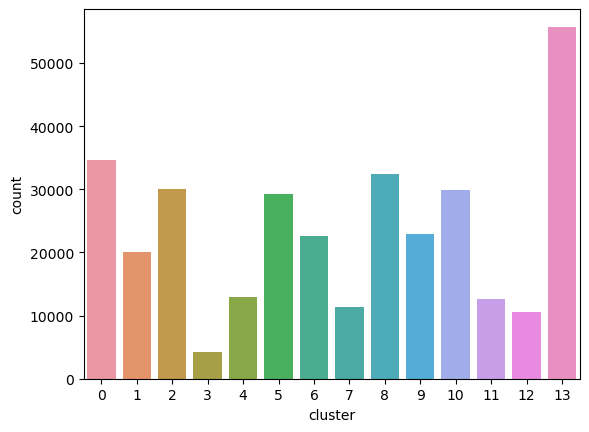

In [15]:
# show distribution of user in every cluster
sns.countplot(data = user_clusters, x = "cluster")

In [16]:
# merge ratings with clusters
cluster_ratings = pd.merge(train_ratings, user_clusters, how="left", on="userId").drop("userId", axis=1)
cluster_ratings

,movieId,rating,cluster
0,1,4.0,2
1,110,4.0,2
2,158,4.0,2
3,260,4.5,2
4,356,5.0,2
...,...,...,...
27065725,8340,2.0,3
27065726,8493,2.5,3
27065727,8622,4.0,3
27065728,8665,3.0,3


In [17]:
# group by cluster and movieId and calculate mean
cluster_ratings = cluster_ratings.groupby(["cluster", "movieId"]).mean()
cluster_ratings

rating
cluster movieId          
0       1        3.837529
        2        3.343185
        3        3.503275
        4        3.410828
        5        3.377468
...                   ...
13      288943   1.500000
        288945   1.000000
        288949   0.500000
        288953   1.500000
        288975   4.000000

[410968 rows x 1 columns]

In [18]:
# write cluster_ratings
cluster_ratings.to_csv('model_data/cluster_ratings.csv') 

In [19]:
average_ranking = train_ratings["rating"].mean()

In [20]:
average_ranking

3.542482670890458

In [21]:
# predict function
def predict(user_id, movie_id):
    try:
        rating = cluster_ratings.at[(user_clusters.at[user_id, "cluster"], movie_id), "rating"]
        
    except KeyError:
        return average_ranking
        
    return rating

In [22]:
# check prediction for average
just_averages = train_ratings.drop("userId", axis=1).groupby("movieId").mean()

In [23]:
def just_average_predict(user_id, movie_id):
    try:
        rating = just_averages.at[movie_id, "rating"]
    except KeyError:
        rating = average_ranking
    return rating

In [24]:
# predict rating for test data
y_predicted = test_pairs.apply(lambda row: predict(row['userId'], row['movieId']), axis=1)

# predict rating 
y_predicted_average = test_pairs.apply(lambda row: just_average_predict(row['userId'], row['movieId']), axis=1)

print("MSE for average")
print(mean_squared_error(y_predicted_average, actual_ratings))


print("MSE for the model")
print(mean_squared_error(y_predicted, actual_ratings))

MSE for average
0.9328423672215757
MSE for the model
0.7809184233810579
